## Simple Control Problem with Neural ODE

In [57]:
%reset -f

In [58]:
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax

import time
from utils import *;

For some reason, GPU is really slow on this task, so let's use CPU

In [59]:
jax.config.update('jax_platform_name', 'cpu')
print(jax.numpy.ones(3).device()) # should be TFRT_CPU_0

TFRT_CPU_0


We are solving the optimal control problem:
\begin{align}
    u^*(t) = \argmin_{u(t)}{J(u)}
\end{align}
- with $J(u) = \frac{1}{2}\left( y(T) - y(0) \right)^2$ (the energy cost is not yet considered)
- subject to the ODE $y'(t) = u(t)$, 
- terminal states $y(0) = y_0$, and $y(T) = y^*$

We want to lean a near-optimal control $\hat u$ by parametrising it via a MLP.

In [92]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *args, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size+1,        ## Input is t and y0
            out_size=data_size,         ## Output is yT
            width_size=width_size,
            depth=depth,
            # activation=jax.nn.softplus,
            activation=lambda x:x,      ## No activation at all
            key=key,
        )

    def __call__(self, t, y, *args):
        input_vec = jnp.array([t, args[0][0]])  ## args[0] is the y0 PyTree (of size 1) - input_vec must be a 1D array to avoid broadcasting
        return self.mlp(input_vec)

In [94]:
T = 1.0
N = 200

data_size = 1
width_size = 1
depth = 0
seed = 3440
key = jax.random.PRNGKey(seed)

test_control = Func(data_size, width_size, depth, key=key)
print("Behold the control term: \n----------------------- \n", test_control)

ts = jnp.linspace(0, T, N)
y0 = jnp.array([1.0])

print("\nTesting the control term: \n----------------------- \n", test_control(ts[0], y0, y0))

Behold the control term: 
----------------------- 
 Func(
  mlp=MLP(
    layers=[
      Linear(
        weight=f32[1,2],
        bias=f32[1],
        in_features=2,
        out_features=1,
        use_bias=True
      )
    ],
    activation=<function <lambda>>,
    final_activation=<function _identity>,
    in_size=2,
    out_size=1,
    width_size=1,
    depth=0
  )
)

Testing the control term: 
----------------------- 
 [0.5599757]


We now deffine the control problem using the Neural ODE formulation.

In [95]:
class NeuralODE(eqx.Module):
    u: Func

    def __init__(self, data_size, width_size, depth, *args, key, **kwargs):
        super().__init__(**kwargs)
        self.u = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.u),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1]-ts[0],
            y0=y0,
            args=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

In [96]:
model = NeuralODE(data_size, width_size, depth, key=key)
model(ts, y0)

DeviceArray([[1.       ],
             [1.0028094],
             [1.0056095],
             [1.0084006],
             [1.0111823],
             [1.0139549],
             [1.0167183],
             [1.0194725],
             [1.0222175],
             [1.0249532],
             [1.0276799],
             [1.0303973],
             [1.0331055],
             [1.0358045],
             [1.0384945],
             [1.041175 ],
             [1.0438465],
             [1.0465088],
             [1.0491619],
             [1.0518057],
             [1.0544404],
             [1.057066 ],
             [1.0596823],
             [1.0622894],
             [1.0648873],
             [1.067476 ],
             [1.0700555],
             [1.0726259],
             [1.075187 ],
             [1.077739 ],
             [1.0802817],
             [1.0828153],
             [1.0853397],
             [1.0878549],
             [1.0903609],
             [1.0928576],
             [1.0953451],
             [1.0978236],
            

Given the target state $y^*$, we can randomly construct training data.

In [97]:
ystar = 1.0 ## target state

def _get_data(ts, *args, key):
    y0 = jax.random.uniform(key, (1,), minval=-2.0, maxval=4.0)
    yT = jnp.array([ystar])
    return jnp.stack([y0, yT], axis=0)     ## data_size is 1

def get_data(dataset_size, *args, key):
    ts = jnp.linspace(0, T, N)
    key = jax.random.split(key, dataset_size)
    ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys

In [98]:
def dataloader(array, batch_size, *args, key):
    dataset_size = array.shape[0]
    indices = jnp.arange(dataset_size)
    perm = jax.random.permutation(key, indices)
    start = 0
    end = batch_size
    while end < dataset_size:
        batch_perm = perm[start:end]
        yield array[batch_perm]
        start = end
        end = start + batch_size

In [99]:
dataset_size = 256
batch_size = 32
data_key, loader_key = jax.random.split(key, 2)

_, ys = get_data(dataset_size, key=data_key)
train_loader = dataloader(ys, batch_size, key=loader_key)

## Test the dataloader
for i, batch in enumerate(train_loader):
    if i < 1: print(batch)

[[[-1.8460891 ]
  [ 1.        ]]

 [[ 2.1999824 ]
  [ 1.        ]]

 [[ 0.22522783]
  [ 1.        ]]

 [[-1.2740948 ]
  [ 1.        ]]

 [[ 1.701261  ]
  [ 1.        ]]

 [[ 1.8390694 ]
  [ 1.        ]]

 [[ 2.4165797 ]
  [ 1.        ]]

 [[-0.2171328 ]
  [ 1.        ]]

 [[-1.2709391 ]
  [ 1.        ]]

 [[ 2.8540394 ]
  [ 1.        ]]

 [[-0.944432  ]
  [ 1.        ]]

 [[-0.60817313]
  [ 1.        ]]

 [[ 3.165923  ]
  [ 1.        ]]

 [[ 3.4304848 ]
  [ 1.        ]]

 [[ 0.58722377]
  [ 1.        ]]

 [[ 3.5716004 ]
  [ 1.        ]]

 [[ 2.8365564 ]
  [ 1.        ]]

 [[ 1.412096  ]
  [ 1.        ]]

 [[ 2.2243454 ]
  [ 1.        ]]

 [[ 3.888111  ]
  [ 1.        ]]

 [[ 1.803999  ]
  [ 1.        ]]

 [[ 2.9412563 ]
  [ 1.        ]]

 [[ 3.7064734 ]
  [ 1.        ]]

 [[ 2.5222945 ]
  [ 1.        ]]

 [[ 1.8798575 ]
  [ 1.        ]]

 [[ 3.9390402 ]
  [ 1.        ]]

 [[ 0.34174728]
  [ 1.        ]]

 [[ 0.7499802 ]
  [ 1.        ]]

 [[ 3.3022509 ]
  [ 1.        ]]

 [[ 2.1772587 

In [100]:
lr = 3e-3
epochs = 500

optim = optax.adabelief(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

@eqx.filter_value_and_grad
def grad_loss(model, ti, yi):
    y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
    return jnp.mean(0.5 * (yi[:, -1] - y_pred[:, -1]) ** 2)

@eqx.filter_jit
def make_step(ti, yi, model, opt_state):
    loss, grads = grad_loss(model, ti, yi)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [101]:
step = 0
for epoch in range(epochs):
    for yi in dataloader(ys, batch_size, key=loader_key):
        start = time.time()
        loss, model, opt_state = make_step(ts, yi, model, opt_state)
        end = time.time()
        step += 1
        if (step % 500) == 0:
            print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

Step: 500, Loss: 0.0009759513195604086, Computation time: 0.01582026481628418
Step: 1000, Loss: 3.134713599806105e-10, Computation time: 0.006026268005371094
Step: 1500, Loss: 1.5267787034645153e-12, Computation time: 0.004885196685791016
Step: 2000, Loss: 7.89313059357255e-13, Computation time: 0.004147529602050781
Step: 2500, Loss: 4.966582700660638e-13, Computation time: 0.004869222640991211
Step: 3000, Loss: 2.619571226603057e-13, Computation time: 0.004916667938232422
Step: 3500, Loss: 1.280642258905118e-13, Computation time: 0.005249500274658203


Let's plot the results, and compare them to the known constant optimal control:
\begin{align}
u^*(t) = \frac{y^* - y_0}{T}
\end{align}

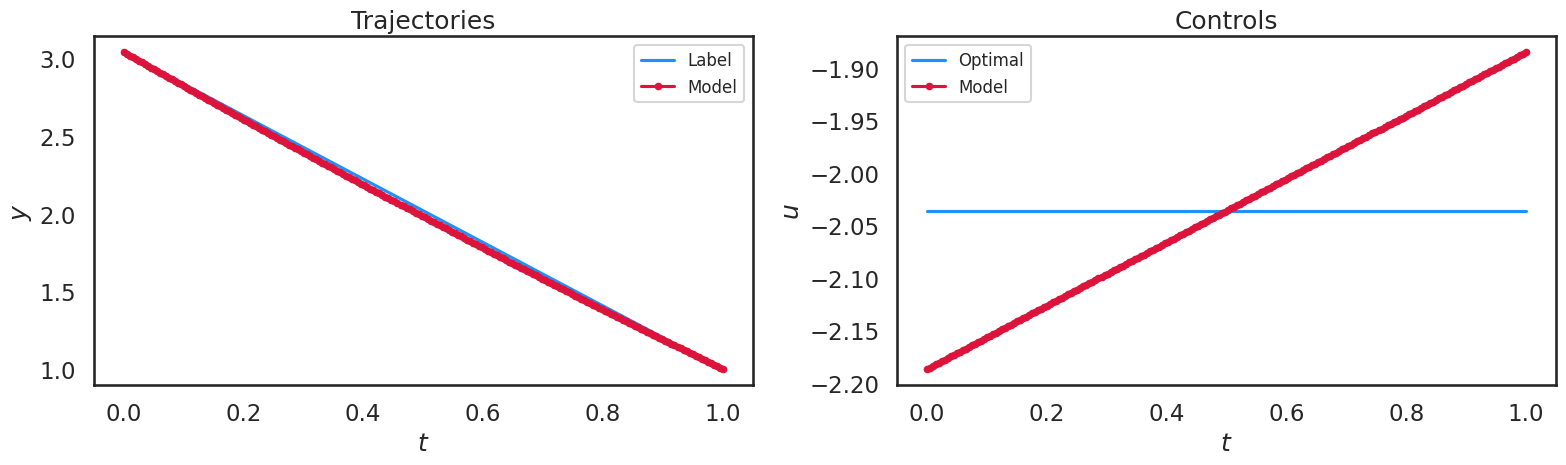

In [102]:
test_key = jax.random.PRNGKey(int(time.time()))
test_point = int(jax.random.uniform(key=test_key, minval=0, maxval=dataset_size))

ytrue = ys[test_point, :]
ypred = model(ts, ys[test_point, 0])[:]
utrue = jnp.ones_like(ytrue) * (ystar-ytrue[0])/T
upred = jax.vmap(model.u, in_axes=(0, None, None))(ts, ypred, ypred[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8*2, 5))
tplot = [ts[0], ts[-1]]
ax1 = plot(tplot, ytrue, c="dodgerblue", label="Label", title="Trajectories", x_label=r"$t$", y_label=r"$y$", ax=ax1)
ax1 = plot(ts, ypred, ".-", c="crimson", label="Model", ax=ax1)

ax2 = plot(tplot, utrue, c="dodgerblue", label="Optimal", title="Controls", x_label=r"$t$", y_label=r"$u$", ax=ax2)
ax2 = plot(ts, upred, ".-", c="crimson", label="Model", ax=ax2)

In [107]:
model.u.mlp.layers[0].bias      ## Should idealy be ystar = 1
# model.u.mlp.layers[0].weight  ## Should idealy be [0, -1]

DeviceArray([0.84906137], dtype=float32)

## Findings
The follwing features were implemented in Neural ODE and interpreted:
- Included control $u$ as a function of $y$: could neither recover trajectories nor controls
- Included control $u$ as a function only of $t$: could not recover trajectories but not too bad on controls
- Included control $u$ as function of both $t$ and $y_0$: could almost perfectly recover trajectories, but completely wrong on optimal controls

## Next steps
- Reduce the MLP size to a single neuron
- Include middle position as extra constraint
- Use SINDy to recover the governing equation for the controls
- Uncertainty quantify the trajectories, especially when initial state is known
- Generate trajectories based on probability density estimation